## Forecasting with sktime

### Reduction: from forecasting to regression

sktime provides a meta-estimator for this approach, which is:

* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **tuneable**, allowing us to tune hyper-parameters like the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformers.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [2]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


In [3]:
from hcrystalball.feature_extraction import SeasonalityTransformer
from hcrystalball.wrappers import (
    ExponentialSmoothingWrapper,
    SarimaxWrapper,
    get_sklearn_wrapper,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

from sktime.forecasting.hcrystalball import HCrystalBallForecaster

In [4]:
# model = SarimaxWrapper(init_with_autoarima=True, autoarima_dict={"m":12})
# model = ExponentialSmoothingWrapper(
#     trend="add",
#     seasonal="multiplicative",
#     seasonal_periods=12
# )
# model = get_sklearn_wrapper(RandomForestRegressor, n_estimators=100)
# model = pipeline = Pipeline([
#     ('seasonality', SeasonalityTransformer(freq='Y')),
#     ('model', get_sklearn_wrapper(RandomForestRegressor))
# ])
# model = get_sklearn_wrapper(ElasticNet)
model = pipeline = Pipeline(
    [
        ("seasonality", SeasonalityTransformer(freq="Y")),
        ("model", get_sklearn_wrapper(ElasticNet)),
    ]
)

In [5]:
forecaster = HCrystalBallForecaster(model=model)
fh = np.arange(len(y_test)) + 1

In [6]:
forecaster.fit(y_train)  # , fh=fh)

HCrystalBallForecaster(model=Pipeline(memory=None,
                                      steps=[('seasonality',
                                              SeasonalityTransformer(auto=True,
                                                                     freq='Y',
                                                                     month_end=False,
                                                                     month_start=False,
                                                                     monthly=None,
                                                                     quarter_end=False,
                                                                     quarter_start=False,
                                                                     quarterly=None,
                                                                     week_day=None,
                                                                     weekly=None,
                                           

In [7]:
y_pred = forecaster.predict(fh)

0.12314345056841892

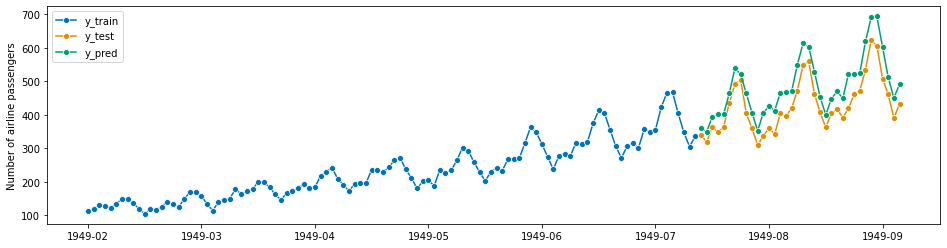

In [8]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

### Statistical forecasters

sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.

Note that since this is monthly data, the seasonal periodicity (sp), or the number of periods per year, is 12.

0.05144409835065696

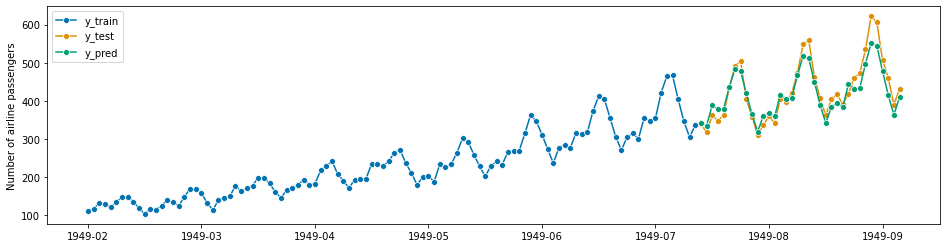

In [9]:
# forecaster = HCrystalBallForecaster(
#     model=ExponentialSmoothingWrapper(
#         trend="add", seasonal="multiplicative", seasonal_periods=12
#     )
# )
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

The exponential smoothing of state space model can also be automated similar
 to the [ets](https://www.rdocumentation.org/packages/forecast/versions/8.13/topics/ets) function in R.

0.05144409835065696

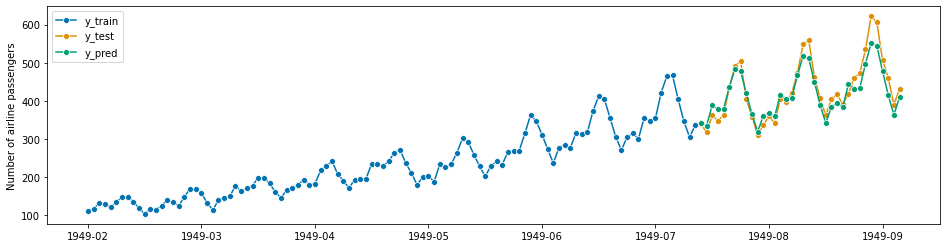

In [10]:
forecaster = HCrystalBallForecaster(
    model=ExponentialSmoothingWrapper(
        trend="add", seasonal="multiplicative", seasonal_periods=12
    )
)
# forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [13]:
# from sktime.forecasting.ets import AutoETS
# forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
# forecaster.fit(y_train)
# y_pred = forecaster.predict(fh)
# plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
# smape_loss(y_test, y_pred)

Another common model is the ARIMA model. In sktime, we interface [pmdarima](https://github.com/alkaline-ml/pmdarima), a package for automatically selecting the best ARIMA model. This since searches over a number of possible model parametrisations, it may take a bit longer.

0.04117062369774063

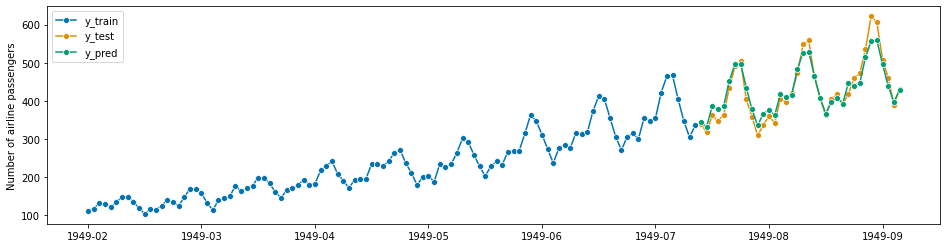

In [14]:
# forecaster = HCrystalBallForecaster(
#     model = SarimaxWrapper(init_with_autoarima=True, autoarima_dict={"m":12})
# )
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.04117062369774063

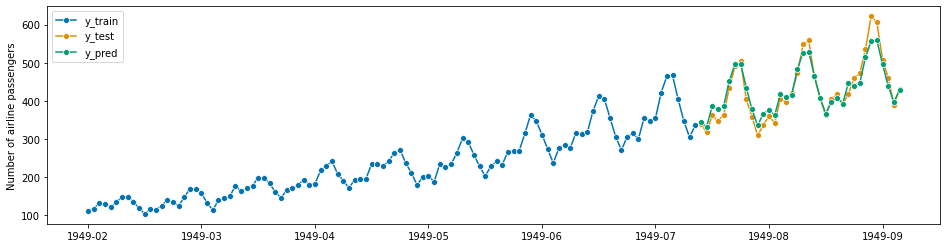

In [15]:
forecaster = HCrystalBallForecaster(
    model=SarimaxWrapper(init_with_autoarima=True, autoarima_dict={"m": 12})
)
# forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

## Composite model building

sktime provides a modular API for composite model building for forecasting.

### Ensembling
Like scikit-learn, sktime provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

0.08005512485078872

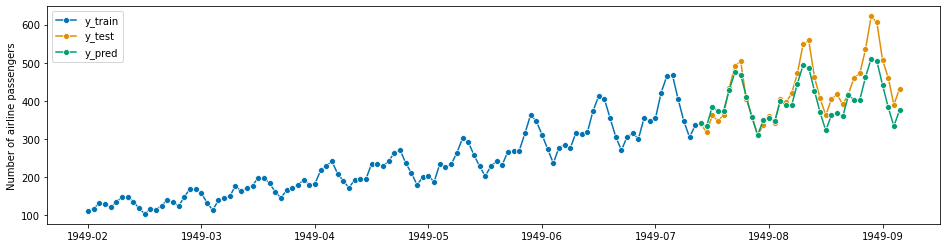

In [15]:
forecaster = EnsembleForecaster(
    [
        ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
        (
            "holt",
            ExponentialSmoothing(
                trend="add", damped=False, seasonal="multiplicative", sp=12
            ),
        ),
        (
            "damped",
            ExponentialSmoothing(
                trend="add", damped=True, seasonal="multiplicative", sp=12
            ),
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

0.08005512485078872

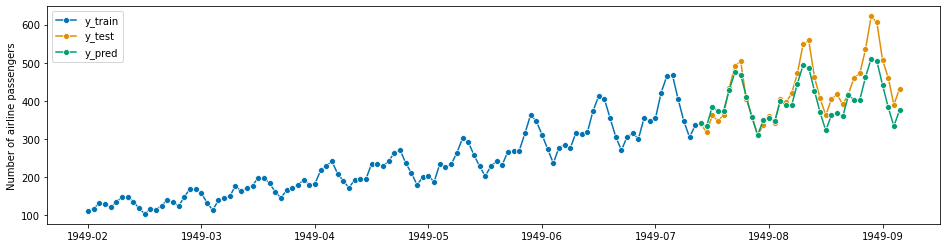

In [16]:
forecaster = EnsembleForecaster(
    [
        (
            "ses",
            HCrystalBallForecaster(
                ExponentialSmoothingWrapper(
                    seasonal="multiplicative", seasonal_periods=12
                )
            ),
        ),
        (
            "holt",
            HCrystalBallForecaster(
                ExponentialSmoothingWrapper(
                    trend="add",
                    damped_trend=False,
                    seasonal="multiplicative",
                    seasonal_periods=12,
                )
            ),
        ),
        (
            "damped",
            HCrystalBallForecaster(
                ExponentialSmoothingWrapper(
                    trend="add",
                    damped_trend=True,
                    seasonal="multiplicative",
                    seasonal_periods=12,
                )
            ),
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

## Tuning
In the `ReducedRegressionForecaster`, both the `window_length` and `strategy` arguments are hyper-parameters which we may want to optimise.

In [17]:
from sklearn.neighbors import KNeighborsRegressor

In [18]:
regressor = KNeighborsRegressor(n_neighbors=1)

In [19]:
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=15, strategy="recursive"
)
param_grid = {"window_length": [5, 10, 15]}

#  we fit the forecaster on the initial window,
# and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

0.14187443909112035

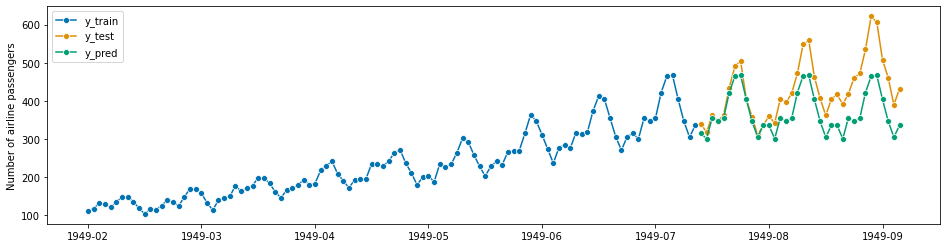

In [20]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [21]:
gscv.best_params_

{'window_length': 15}

Using scikit-learn's `GridSearchCV`, we can tune regressors imported from scikit-learn, in addition to tuning `window_length`.

0.12489457696398037

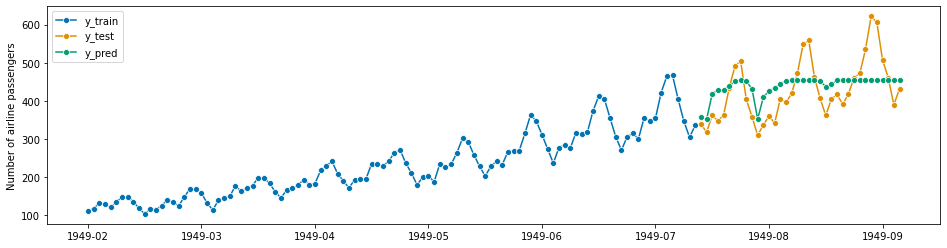

In [22]:
from sklearn.model_selection import GridSearchCV

# tuning the 'n_estimator' hyperparameter of RandomForestRegressor from scikit-learn
regressor_param_grid = {"n_estimators": [100, 200, 300]}
forecaster_param_grid = {"window_length": [5, 10, 15, 20, 25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = ReducedRegressionForecaster(
    regressor, window_length=15, strategy="recursive"
)

cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)

gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

In [23]:
print(gscv.best_params_, gscv.best_forecaster_.regressor_.best_params_)

{'window_length': 25} {'n_estimators': 200}


To access performance on a particular metric during tuning, we can use the `scoring` argument of `ForecastingGridSearchCV`.

In [24]:
gscv = ForecastingGridSearchCV(
    forecaster, cv=cv, param_grid=forecaster_param_grid, scoring=sMAPE()
)
gscv.fit(y_train)
pd.DataFrame(gscv.cv_results_)

,mean_fit_time,mean_score_time,param_window_length,params,mean_test_sMAPE,rank_test_sMAPE
0,8.046260,2.328793,5,{'window_length': 5},0.301492,5
1,8.277061,1.439380,10,{'window_length': 10},0.266925,4
2,7.620496,2.275145,15,{'window_length': 15},0.246816,2
3,5.571184,0.726434,20,{'window_length': 20},0.248123,3
4,4.007300,0.688215,25,{'window_length': 25},0.237570,1


### Detrending
Note that so far the reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data.

sktime provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

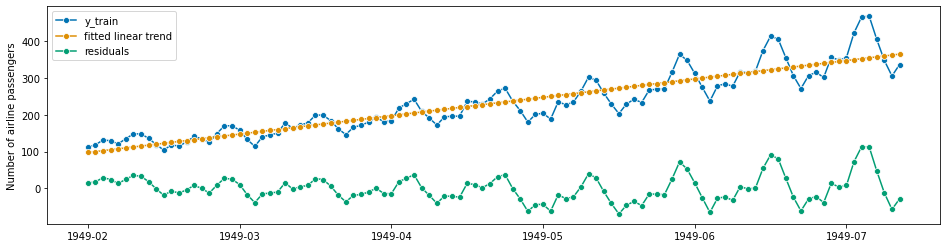

In [25]:
# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample
# predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train))  # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_series(y_train, y_pred, yt, labels=["y_train", "fitted linear trend", "residuals"]);

### Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

0.05447876401482237

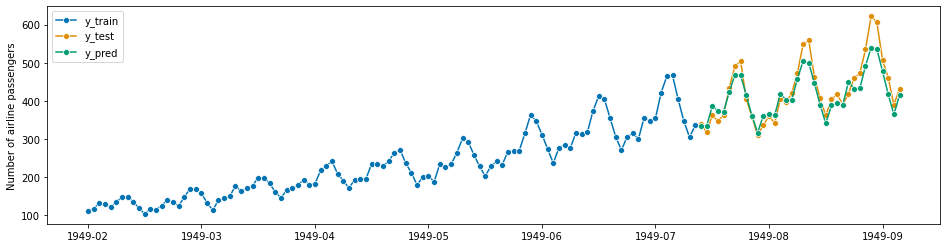

In [26]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        (
            "forecast",
            ReducedRegressionForecaster(
                regressor=regressor, window_length=12, strategy="recursive"
            ),
        ),
    ]
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

Below we discuss two other aspects of forecasting: online learning, where we want to dynamically update forecasts as new data comes in, and prediction intervals, which allow us to quantify the uncertainty of our forecasts.

## Dynamic forecasts

For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, all forecasters in sktime have a `update_predict` method. Here we make repeated single-step ahead forecasts over the test set.

Note that the forecasting task is changed: while we still make 36 predictions, we do not predict 36 steps ahead, but instead make 36 single-step-ahead predictions.

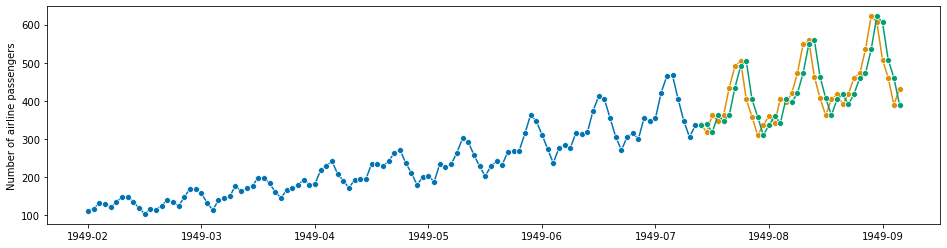

In [27]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
smape_loss(y_test, y_pred)
plot_series(y_train, y_test, y_pred);

For a single update, you can use the `update` method.

## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. sktime's interface support prediction intervals, but we haven't implemented them for all algorithms yet.

Here, we use the Theta forecasting algorithm:

In [28]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

0.08661468139978168

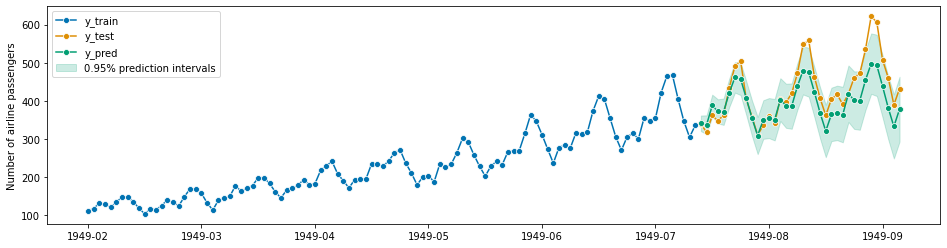

In [29]:
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

## Summary

As we have seen, in order to make forecasts, we need to first specify (or build) a model, then fit it to the training data, and finally call predict to generate forecasts for the given forecasting horizon.

* sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

* sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write the following.


## Useful resources
* For more details, take a look at [our paper on forecasting with sktime](https://arxiv.org/abs/2005.08067) in which we discuss the forecasting API in more detail and use it to replicate and extend the M4 study.
* For a good introduction to forecasting, see [Hyndman, Rob J., and George Athanasopoulos. Forecasting: principles and practice. OTexts, 2018](https://otexts.com/fpp2/).
* For comparative benchmarking studies/forecasting competitions, see the [M4 competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) and the currently running [M5 competition](https://www.kaggle.com/c/m5-forecasting-accuracy/overview).